### [MAPLEAF.ENV](https://henrystoldt.github.io/MAPLEAF/ENV/index.html)
For the rocket to compute the forces it experiences it needs to know about its environment.

Environmental modelling in MAPLEAF is divided into modelling of:
- Mean winds -> MAPLEAF.ENV.MeanWindModelling
- Air turbulence -> MAPLEAF.ENV.TurbulenceModelling
- Air properties (temp, pressure, density, viscosity) -> MAPLEAF.ENV.AtmosphereModelling
- Gravity -> MAPLEAF.ENV.EarthModelling
- Earth's surface and rotation -> MAPLEAF.ENV.EarthModelling

Each of these modules defines a 'factory' function, which reads info from a SimDefinition, and then returns an appropriate model object.
            
All the models end up tied together by the Environment class, which is what the rocket communicates with to figure out what its flying through.

**Mean Wind Modelling** can take several forms:
- Constant wind (Deterministic)
- Hellman (Deterministic)
- Custom Profile (Deterministic)
- SampledGroundWind (Probabilistic)
- SampledRadioSondeData (Probabilistic)

<class 'MAPLEAF.ENV.MeanWindModelling.ConstantWind'>


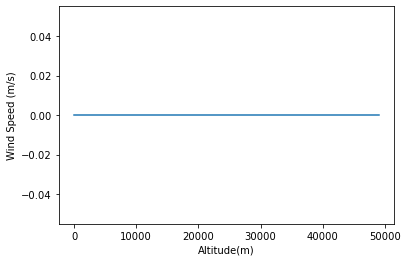

In [1]:
from MAPLEAF.ENV import meanWindModelFactory
from MAPLEAF.IO import SimDefinition, SubDictReader
import matplotlib.pyplot as plt

simDef = SimDefinition("MAPLEAF/Examples/Simulations/Wind.mapleaf")
envReader = SubDictReader("Environment", simDef)

### Remove keys that make probabilistic models deterministic
randomSeedKeys = simDef.findKeysContaining("randomSeed")
for key in randomSeedKeys:
    simDef.removeKey(key)
    
# Try out constant model (default)
windModel = meanWindModelFactory()

def plotWinds(model):
    altitudes = list(range(0, 50000, 1000))
    winds = [ model.getMeanWind(a).length() for a in altitudes]
    plt.plot(altitudes, winds)
    plt.xlabel("Altitude(m)")
    plt.ylabel("Wind Speed (m/s)")
    
print(type(windModel))
plotWinds(windModel)

<class 'MAPLEAF.ENV.MeanWindModelling.Hellman'>


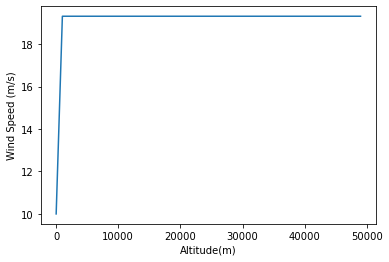

In [2]:
# Hellman is a simple model for very low altitudes
simDef.setValue("Environment.MeanWindModel", "Hellman")
windModel = meanWindModelFactory(envReader, silent=True)

print(type(windModel))
plotWinds(windModel)

<class 'MAPLEAF.ENV.MeanWindModelling.ConstantWind'>


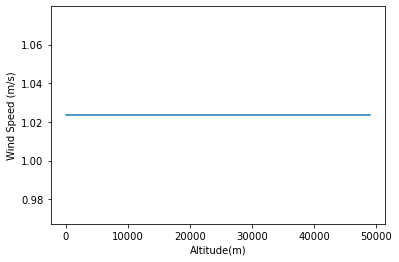

In [3]:
# Sampling wind probability ditributions from wind rose datas
simDef.setValue("Environment.MeanWindModel", "SampledGroundWindData")
windModel = meanWindModelFactory(envReader, silent=True)

print(type(windModel))
plotWinds(windModel)

<class 'MAPLEAF.ENV.MeanWindModelling.InterpolatedWind'>


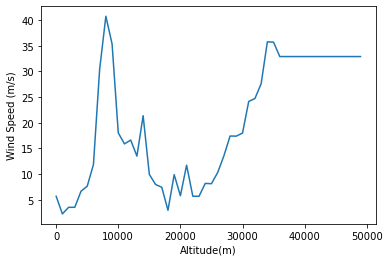

In [4]:
# Sampling entire radio sonde wind profiles
simDef.setValue("Environment.MeanWindModel", "SampledRadioSondeData")
windModel = meanWindModelFactory(envReader, silent=True)

print(type(windModel))
plotWinds(windModel)

**Turbulence Modelling** has three general possibilities:
- Pink Noise Models (probabilistic, depends on mean wind)
- Custom gust (deterministic, doesn't depend on mean wind)
- None (default)

<class 'MAPLEAF.ENV.TurbulenceModelling.PinkNoise3D'>


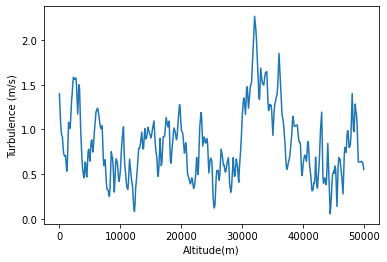

In [5]:
from MAPLEAF.ENV import turbulenceModelFactory
simDef.setValue("Environment.MeanWindModel", "Constant")
meanWindModel = meanWindModelFactory(envReader, silent=True)

simDef.setValue("Environment.TurbulenceModel", "PinkNoise3D")
turbModel = turbulenceModelFactory(envReader, silent=True)

def plotTurb(turbModel, meanWindModel):
    altitudes = list(range(0, 50000, 100))
    times = [ x/50 for x in range(1000) ]
    meanWinds = [ meanWindModel.getMeanWind(a) for a in altitudes ]
    turbComponent = [ turbModel.getTurbVelocity(altitude=a, meanWindVelocity=m, time=t).length() for a,m,t in zip(altitudes, meanWinds, times)]
    
    plt.plot(altitudes, turbComponent)
    plt.xlabel("Altitude(m)")
    plt.ylabel("Turbulence (m/s)")
    
print(type(turbModel))
plotTurb(turbModel, meanWindModel)

<class 'MAPLEAF.ENV.TurbulenceModelling.CustomSineGust'>


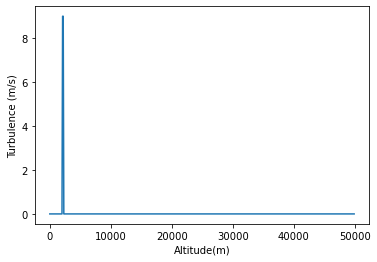

In [6]:
simDef.setValue("Environment.TurbulenceModel", "customSineGust")
turbModel = turbulenceModelFactory(envReader, silent=True)
print(type(turbModel))
plotTurb(turbModel, meanWindModel)

**Air/Atmospheric Properties** can be modelled as either:
- US Standard Atmosphere (up to 86km atm)
- Constant properties
- Custom Table

<class 'MAPLEAF.ENV.AtmosphereModelling.USStandardAtmosphere'>


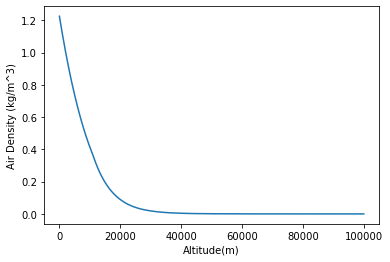

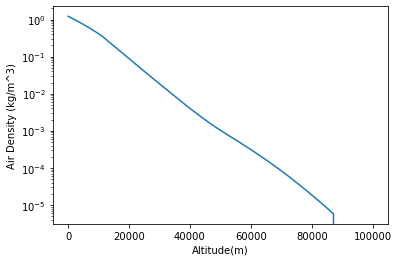

In [7]:
from MAPLEAF.ENV import atmosphericModelFactory
# US Standard Atmosphere is default
atmModel = atmosphericModelFactory()

def plotDensity(model):
    altitudes = range(0, 100000, 100)
    airDensities = [ model.getAirProperties(a, 0)[2] for a in altitudes ]
    plt.plot(altitudes, airDensities)
    plt.xlabel("Altitude(m)")
    plt.ylabel("Air Density (kg/m^3)")
    plt.show()
    
    plt.plot(altitudes, airDensities)
    plt.xlabel("Altitude(m)")
    plt.ylabel("Air Density (kg/m^3)")
    plt.yscale("log")
    plt.show()
    
print(type(atmModel))
plotDensity(atmModel)

<class 'MAPLEAF.ENV.AtmosphereModelling.ConstantAtmosphere'>


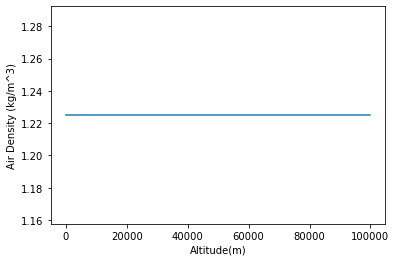

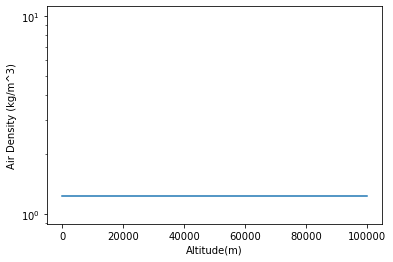

In [8]:
from MAPLEAF.ENV import atmosphericModelFactory
simDef.setValue("Environment.AtmosphericPropertiesModel", "Constant")
atmModel = atmosphericModelFactory(envReader)    
print(type(atmModel))
plotDensity(atmModel)

<class 'MAPLEAF.ENV.AtmosphereModelling.TabulatedAtmosphere'>


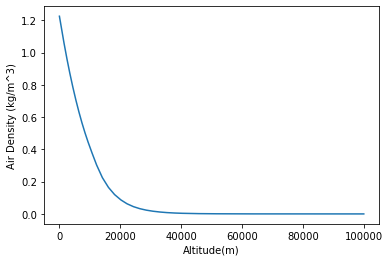

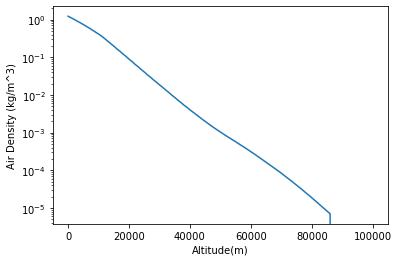

In [9]:
from MAPLEAF.ENV import atmosphericModelFactory
simDef.setValue("Environment.AtmosphericPropertiesModel", "TabulatedAtmosphere")
simDef.setValue("Environment.TabulatedAtmosphere.filePath", "MAPLEAF/ENV/US_Standard_Atmosphere.txt")
atmModel = atmosphericModelFactory(envReader)    
print(type(atmModel))
plotDensity(atmModel)

**Earth Models** available:
- None (No gravity)
- Flat (Inverse square gravity)
- Round (Inverse square gravity, long/lat a bit wrong)
- WGS84 (Ellipsoidal, long/lat correct)

Set launch location with 'Environment.launchSite'

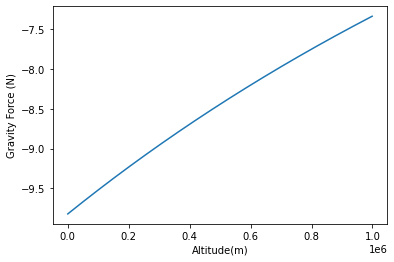

In [10]:
from MAPLEAF.ENV import earthModelFactory
# Default is flatEarth
flatEarth = earthModelFactory()

def plotGravity(earthModel, initZ=0):
    from MAPLEAF.Motion import Inertia, Vector, RigidBodyState
    inertia = Inertia(Vector(1,1,1), CG=Vector(0,0,0), mass=1)
    state = RigidBodyState()
    
    altitudes = range(0, 1000000, 1000)
    gravityZForces = []
    for a in altitudes:
        state.position.Z = a+initZ
        gravityForce = earthModel.getGravityForce(inertia, state)
        gravityZForces.append(gravityForce.Z)
        
    plt.plot(altitudes, gravityZForces)
    plt.xlabel("Altitude(m)")
    plt.ylabel("Gravity Force (N)")
    
plotGravity(flatEarth)

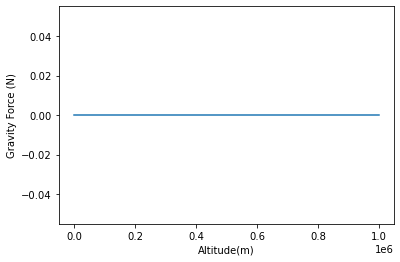

In [11]:
simDef.setValue('Environment.EarthModel', 'None')
noEarth = earthModelFactory(envReader)
plotGravity(noEarth)

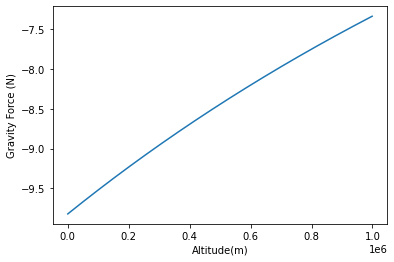

In [12]:
simDef.setValue('Environment.EarthModel', 'Round')
roundEarth = earthModelFactory(envReader)
plotGravity(roundEarth, initZ=6371000) # Earth's radius is ~6371km

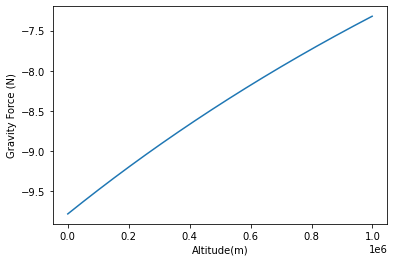

In [13]:
simDef.setValue('Environment.EarthModel', 'WGS84')
wgs84Earth = earthModelFactory(envReader)
plotGravity(wgs84Earth, initZ=6371000) # Earth's radius is ~6371km

**Launch Rails**  
Code Not covered in here, but also in MAPLEAF.ENV is the launch rail class. A launch rail applies several constraints to the rocket's initial motion.
- Can't travel downward
- Must travel along initial direction

Constraints are removed once the rocket's CG has moved by the length of the launch rail

The **Environment** class pulls together all the things discussed above, and provides a unified interface for all of them, which is used by the rocket.
The important functions are getAirProperties(position, time) and getGravityForce(inertia, state):

In [14]:
from MAPLEAF.ENV import Environment
from MAPLEAF.Motion import RigidBodyState, Vector, Inertia

env = Environment()
inertia = Inertia(Vector(1,1,1), Vector(0,0,0), 1)
state = RigidBodyState() # Default is all zero positions

air = env.getAirProperties(state.position, 0)

print(air)
print("")
print(air.Wind)

EnvironmentalConditions(ASLAltitude=0.0, Temp=288.15, Pressure=101324.99999999996, Density=1.2249991558877118, DynamicViscosity=1.7881529939362402e-05, Wind=<MAPLEAF.Motion.CythonVector.Vector object at 0x0000011599C25B70>, MeanWind=<MAPLEAF.Motion.CythonVector.Vector object at 0x0000011599C25C60>, TurbWind=<MAPLEAF.Motion.CythonVector.Vector object at 0x0000011599C25BD0>)

(0.0 0.0 0.0)


In [15]:
print(env.getGravityForce(inertia, state))

Force=(0.0 0.0 -9.820251920927312) At=(0.0 0.0 0.0) + Moment=(0.0 0.0 0.0)


With a round-earth model, the gravity is actual different in different locations:

In [16]:
env = Environment(simDef, silent=True)
print(env.earthModel)

northPolePos = Vector(*env.earthModel.geodeticToCartesian(lat=90, lon=0, height=0))
calgaryPos = Vector(*env.earthModel.geodeticToCartesian(lat=51.071585, lon=-114.125204, height=700))
guianaSpaceCentrePos = Vector(*env.earthModel.geodeticToCartesian(lat=5.167596, lon=-52.683439, height=0))

print("\nLocations: ")
print("North Pole:          {:1.0e}".format(northPolePos))
print("Calgary:             {:1.0e}".format(calgaryPos))
print("Guiana Space Centre: {:1.0e}\n".format(guianaSpaceCentrePos))

print("Gravity:")
state.position = northPolePos
print("North Pole:          {:1.3f}".format(env.getGravityForce(inertia, state).force.length()))
state.position = calgaryPos
print("Calgary:             {:1.3f}".format(env.getGravityForce(inertia, state).force.length()))
state.position = guianaSpaceCentrePos
print("Guiana Space Centre: {:1.3f}\n".format(env.getGravityForce(inertia, state).force.length()))



Locations: 
North Pole:          4e-10 0e+00 6e+06
Calgary:             -2e+06 -4e+06 5e+06
Guiana Space Centre: 4e+06 -5e+06 6e+05

Gravity:
North Pole:          9.832
Calgary:             9.823
Guiana Space Centre: 9.814

